In [36]:
# 首先 import 一些主要的包
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import torch

# 画图使用
%matplotlib inline

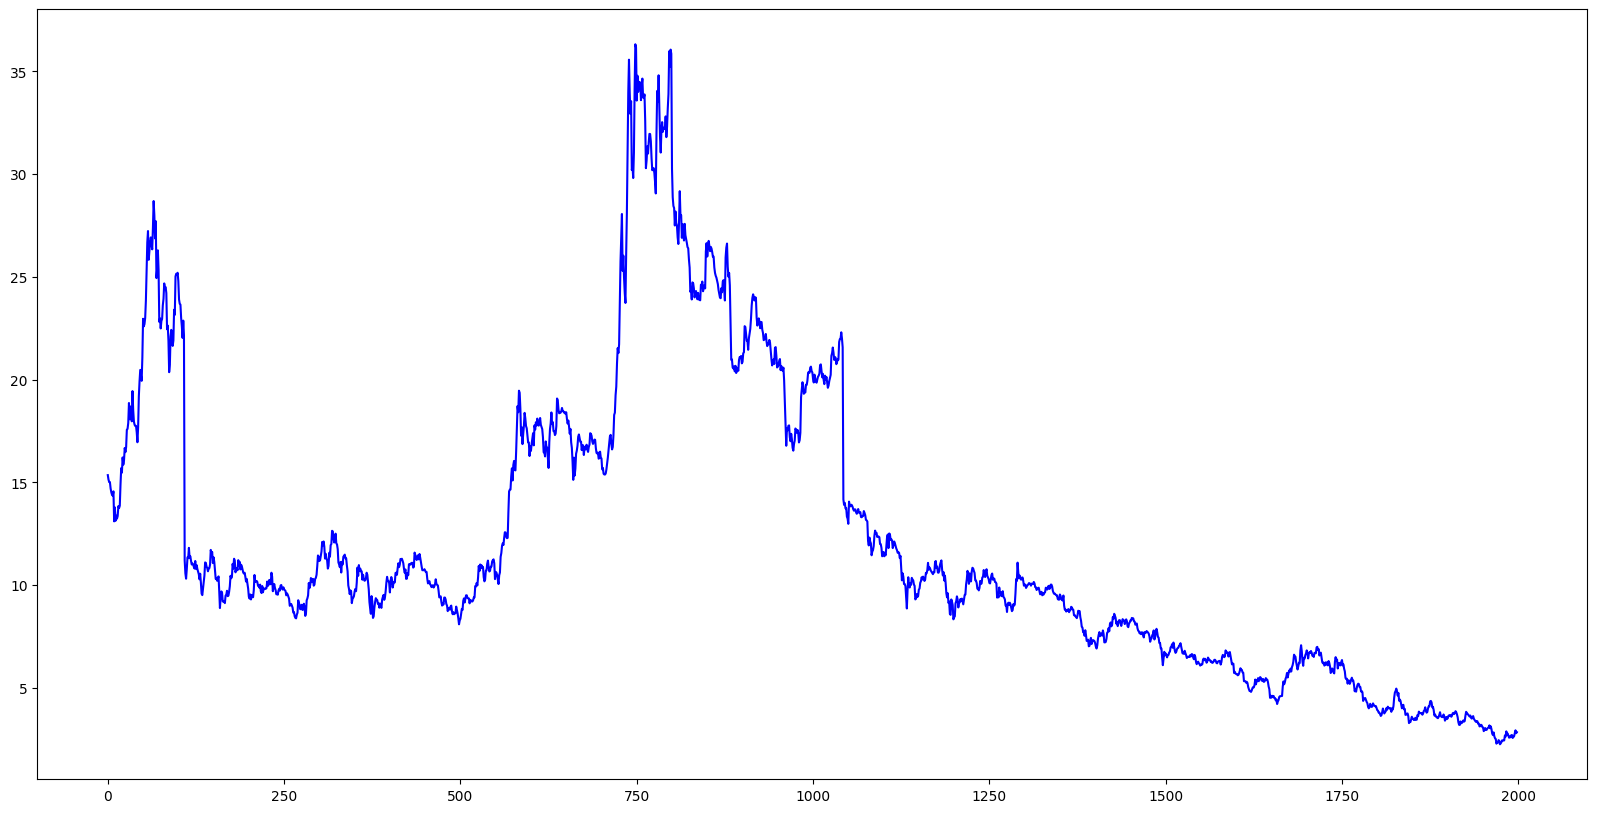

In [37]:
data = np.load('train_data.npy')
plt.figure(figsize=(20,10))
plt.plot(data,c='blue')
plt.show()

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(np.array([0, 300]).reshape(-1, 1))

In [39]:
# 生成题目所需的训练集合
def generate_data(data):
    
    # 记录 data 的长度
    n = data.shape[0]
    
    # 目标是生成可直接用于训练和测试的 x 和 y
    x = []
    y = []
        
    # 建立 (14 -> 1) 的 x 和 y
    for i in range(15, n):
        x.append(data[i-15:i-1])
        y.append(data[i-1])
            
    # 转换为 numpy 数组
    x = np.array(x)
    y = np.array(y)
        
    return x,y

In [40]:
# 生成 train valid test 集合，以供训练所需
def generate_training_data(x, y):
    # 样本总数
    num_samples = x.shape[0]
    # 测试集大小
    num_test = round(num_samples * 0.2)
    # 训练集大小
    num_train = round(num_samples * 0.7)
    # 校验集大小
    num_val = num_samples - num_test - num_train
    
    # 训练集拥有从 0 起长度为 num_train 的样本
    x_train, y_train = x[:num_train], y[:num_train]
    # 校验集拥有从 num_train 起长度为 num_val 的样本
    x_val, y_val = (
        x[num_train: num_train + num_val],
        y[num_train: num_train + num_val],
    )
    # 测试集拥有尾部 num_test 个样本
    x_test, y_test = x[-num_test:], y[-num_test:]
    
    # 返回这些集合
    return x_train, y_train, x_val, y_val, x_test, y_test

In [41]:
# 获取数据中的 x, y
x,y = generate_data(data)
# 将 x,y 转换乘 tensor ， Pytorch 模型默认的类型是 float32
x = torch.tensor(x)
y = torch.tensor(y)
# 将 y 转化形状
y = y.view(y.shape[0],1)
# 对 x, y 进行 minmaxscale
x_scaled = scaler.transform(x.reshape(-1,1)).reshape(-1,14)
y_scaled = scaler.transform(y)

x_scaled = torch.tensor(x_scaled, dtype=torch.float32)
y_scaled = torch.tensor(y_scaled, dtype=torch.float32)
x_train, y_train, x_val, y_val, x_test, y_test = generate_training_data(x_scaled, y_scaled)

In [42]:
# 建立一个自定 Dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
 
    def __getitem__(self, item):
        return self.x[item], self.y[item]
 
    def __len__(self):
        return len(self.x)
# 建立训练数据集、校验数据集和测试数据集
train_data = MyDataset(x_train,y_train)
valid_data = MyDataset(x_val,y_val)
test_data = MyDataset(x_test,y_test)
# 规定批次的大小
batch_size = 512

# 创建对应的 DataLoader
train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 校验集和测试集的 shuffle 是没有必要的，因为每次都会全部跑一遍
valid_iter = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [45]:
from flaml import AutoML
automl = AutoML()
automl.fit(X_train=x_train.numpy(), y_train=y_train.numpy(), X_val=x_val.numpy(),y_val=y_val.numpy(),task="regression",metric='mae',time_budget=100,early_stop=True)

[flaml.automl: 12-02 21:29:30] {2600} INFO - task = regression
[flaml.automl: 12-02 21:29:30] {2602} INFO - Data split method: uniform
[flaml.automl: 12-02 21:29:30] {2605} INFO - Evaluation method: holdout
[flaml.automl: 12-02 21:29:30] {2727} INFO - Minimizing error metric: mae
[flaml.automl: 12-02 21:29:30] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 12-02 21:29:30] {3164} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-02 21:29:30] {3297} INFO - Estimated sufficient time budget=48s. Estimated necessary time budget=0s.
[flaml.automl: 12-02 21:29:30] {3344} INFO -  at 0.0s,	estimator lgbm's best error=0.0209,	best estimator lgbm's best error=0.0209
[flaml.automl: 12-02 21:29:30] {3164} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-02 21:29:30] {3344} INFO -  at 0.0s,	estimator lgbm's best error=0.0209,	best estimator lgbm's best error=0.0209
[flaml.automl: 12-02 21:29:30] {3164} INFO

In [46]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best f1 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: extra_tree
Best hyperparmeter config: {'n_estimators': 5, 'max_features': 0.9133703772386395, 'max_leaves': 676}
Best f1 on validation data: 0.9988
Training duration of best run: 0.02191 s


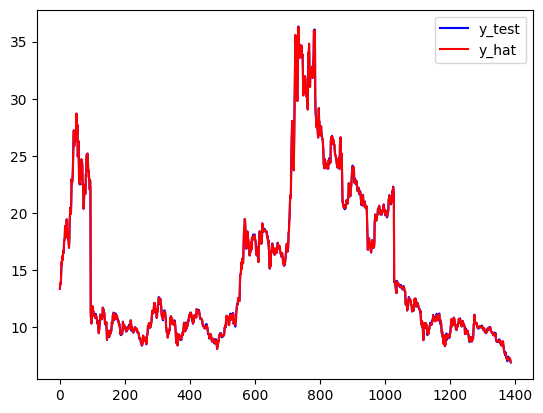

In [49]:
y_hat = automl.predict(x_train.numpy())
plt.plot(scaler.inverse_transform(y_train.reshape(-1,1)).reshape(-1), c='blue', label='y_test')
plt.plot(scaler.inverse_transform(y_hat.reshape(-1,1)).reshape(-1), c='red', label='y_hat')
plt.legend()
plt.show()